# Sentiment Analysis for Steam Reviews
Steam is a video game digital distribution service with a vast community of gamers globally. A lot of gamers write reviews at the game page and have an option of choosing whether they would recommend this game to others or not. However, determining this sentiment automatically from text can help Steam to automatically tag such reviews extracted from other forums across the internet and can help them better judge the popularity of games.

Given the review text with user recommendation and other information related to each game for 64 game titles, the task is to predict whether the reviewer recommended the game titles available in the test set on the basis of review text and other information.

Game overview information for both train and test are available in single file game_overview.csv inside train.zip

# Data Dictionary 

# Training data set

review_id             :  Unique ID for each review

title                 :  Title of the game

year                  :  Year in which the review was posted

user_review           :  Full Text of the review posted by a user

user_suggestion       :  (Target) Game marked Recommended(0) and Not Recommended(1) by the user



# Game overview data set
    
title : Title of the game

developer : Name of the developer of the game

publisher : Name of the publisher of the game

tags : Popular user defined tags for the game

overview : Overview of the game provided by the publisher.

# Submission Data set

review_id : review_id  in order as given in test.csv

user_suggestion : Your prediction whether the particular review was recommended (1) or not (0)

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import naive_bayes,svm,ensemble
from sklearn.svm import LinearSVC
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,classification_report
import string
import nltk
from nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from scipy.sparse import hstack,csr_matrix
from   nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud
stop_words = set(stopwords.words("english"))


#pd.set_option('display.max_colwidth',200)

In [22]:
pd.set_option('display.max_colwidth',200)

In [2]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [3]:
# read the train and test file and explore the datasets
train = pd.read_csv('train.csv')
train.head()

review_id                        title    year  \
0          1  Spooky's Jump Scare Mansion  2016.0   
1          2  Spooky's Jump Scare Mansion  2016.0   
2          3  Spooky's Jump Scare Mansion  2016.0   
3          4  Spooky's Jump Scare Mansion  2015.0   
4          5  Spooky's Jump Scare Mansion  2015.0   

                                         user_review  user_suggestion  
0  I'm scared and hearing creepy voices.  So I'll...                1  
1  Best game, more better than Sam Pepper's YouTu...                1  
2  A littly iffy on the controls, but once you kn...                1  
3  Great game, fun and colorful and all that.A si...                1  
4  Not many games have the cute tag right next to...                1

In [5]:
train['user_review'] = train['user_review'].apply(lambda x : x.encode('utf-8', 'ignore'))

In [23]:
train[train.user_suggestion == 0][['user_review','user_suggestion']].sample(5)

user_review  \
652          Early Access ReviewI don't know if this game is still like this but my experience was purely awful it is an average fps nothing new with not to-new graphics but I hate this game I give it 5/10   
3560  Early Access ReviewCan't change the resolution and I have a 4k monitor so it's pretty taxing. Also it freezes for 20 seconds every 5 minutes. I have a 1080 ti too so a gmae like this shouldn't be ...   
6162  PLUSES: Free to Play, Working with Steam, No premium weapons, vehicles or things like that, You can set name for your gun, soldier, squad and unit, Game about World War II.FIXED Number of cheaters...   
9811  i played Elsword before there even was Elesis, i quit when it got repetive. while i desided to try it again, having heard that alot of changes had been made.. well that didn't last long, i started...   
3245  Access ReviewNEVER EVER play any game developed by Tencent!--------------------------------Direct quote from RoE's Privacy Policy, Last Updated Nov.20th, 2018:Information we collect about you. We ...   

      user_suggestion  
652                 0  
3560                0  
6162                0  
9811                0  
3245                0

In [24]:
train[train.user_suggestion == 1][['user_review','user_suggestion']].sample(5)

user_review  \
5986   This is the best modern flight simulator in the market right now. DCS World is seperated into two types of modules: 'DCS' level and 'Flaming Cliffs' level. DCS level aircraft such as the A-10C, th...   
4639   Currently my favorite game.Really fun MOBA with normal movement, TPS camera, "skillshots" and a hella lot of fun.It isn't p2w, you can get the normal currency very easily by playing/logging in and...   
3150        A much better game than World of Warplanes, one of the best simulators you will find were you can actually use a mouse and keyboard and be awsum. would definately have a go if you havent already   
2052   FULL Voice Acting+ Equipped Items Show+ Dramatic Game Changing Classes+ Hard to play alone- No Tutorial- Good Plot/Story+ Okay Combat -/+ Amazing Graphics+ Great Gameplay+ Doesn't Require a Powerf...   
15540  I've played many clicker games but this one keeps my attention for a wide variety of reasons. I know many people don't like long reviews to read so i'll kepe each point short.1. Formations. Each o...   

       user_suggestion  
5986                 1  
4639                 1  
3150                 1  
2052                 1  
15540                1

In [25]:
# shape of train data set
train.shape

(17494, 5)

In [26]:
# check for null values
train.isnull().sum()

review_id            0
title                0
year               178
user_review          0
user_suggestion      0
dtype: int64

In [27]:
# Reviews present from 2011 till 2018
train['year'].min(),train['year'].max()

(2011.0, 2018.0)

In [28]:

# check the data type of train dataset
train.dtypes

review_id            int64
title               object
year               float64
user_review         object
user_suggestion      int64
dtype: object

In [29]:
# check year wise user suggestion counts
train.groupby(train['year']).count()

review_id  title  user_review  user_suggestion
year                                                  
2011.0         14     14           14               14
2012.0         65     65           65               65
2013.0        340    340          340              340
2014.0       1499   1499         1499             1499
2015.0       2460   2460         2460             2460
2016.0       4226   4226         4226             4226
2017.0       3890   3890         3890             3890
2018.0       4822   4822         4822             4822

In [30]:
# explore blank year data
train[train.year.isnull()]

review_id                                               title  year  \
1027        1028                                     Fractured Space   NaN   
1642        2106                                              Dota 2   NaN   
1811        2275                                              Dota 2   NaN   
1814        2278                                              Dota 2   NaN   
1888        2352                                              Dota 2   NaN   
1889        2353                                              Dota 2   NaN   
2388        2852                                       Path of Exile   NaN   
2418        2882                                       Path of Exile   NaN   
2431        2895                                       Path of Exile   NaN   
2601        3065                                         War Thunder   NaN   
2640        3104                                         War Thunder   NaN   
2652        3116                                         War Thunder   NaN   
2658        3122                                         War Thunder   NaN   
2782        3246                                         War Thunder   NaN   
2785        3249                                         War Thunder   NaN   
2792        3256                                         War Thunder   NaN   
2905        3369                                         War Thunder   NaN   
2934        3398                                         War Thunder   NaN   
2944        3408                                         War Thunder   NaN   
2946        3410                                         War Thunder   NaN   
2948        3412                                         War Thunder   NaN   
2978        3442                                         War Thunder   NaN   
2986        3450                                         War Thunder   NaN   
3110        3574                                         War Thunder   NaN   
3113        3577                                         War Thunder   NaN   
3115        3579                                         War Thunder   NaN   
3185        3649                                     Ring of Elysium   NaN   
3189        3653                                     Ring of Elysium   NaN   
3195        3659                                     Ring of Elysium   NaN   
3199        3663                                     Ring of Elysium   NaN   
...          ...                                                 ...   ...   
13509      19453                                         Creativerse   NaN   
14392      20719                                         Shop Heroes   NaN   
14531      21642                                           Robocraft   NaN   
15016      22127                                           Robocraft   NaN   
15309      22420  Business Tour - Board Game with Online Multiplayer   NaN   
15653      23088                                   AdventureQuest 3D   NaN   
15654      23089                                   AdventureQuest 3D   NaN   
15682      23117                                   AdventureQuest 3D   NaN   
15819      23254                                   AdventureQuest 3D   NaN   
15824      23259                                   AdventureQuest 3D   NaN   
16225      23660                                       Realm Grinder   NaN   
16231      23666                                       Realm Grinder   NaN   
16539      24508                                   Bloons TD Battles   NaN   
16669      24638                                   Bloons TD Battles   NaN   
16670      24639                                   Bloons TD Battles   NaN   
16671      24640                                   Bloons TD Battles   NaN   
16672      24641                                   Bloons TD Battles   NaN   
16697      24666                                   Bloons TD Battles   NaN   
16717      24686                                   Bloons TD Battles   NaN   
16779      24748             

In [31]:
# number of unique titles in the train set
train['title'].nunique()

44

In [32]:
# number of reviews per title

train.groupby(['title']).count()

review_id  year  \
title                                                                 
AdventureQuest 3D                                         519   514   
Black Squad                                               288   288   
Bless Online                                              712   700   
Bloons TD Battles                                         233   226   
Brawlhalla                                                410   407   
Business Tour - Board Game with Online Multiplayer        191   190   
Creativerse                                               492   486   
Crusaders of the Lost Idols                               132   132   
Cuisine Royale                                            399   390   
DCS World Steam Edition                                   488   482   
Dota 2                                                    405   400   
Dreadnought                                                60    60   
Elsword                                                   342   342   
Eternal Card Game                                         791   780   
EverQuest II                                               69    67   
Fallout Shelter                                           447   445   
Fractured Space                                           718   717   
Freestyle 2: Street Basketball                             57    57   
Heroes & Generals                                         745   737   
Infestation: The New Z                                    479   479   
Neverwinter                                               546   545   
Path of Exile                                             458   455   
PlanetSide 2                                              472   470   
RaceRoom Racing Experience                                416   413   
Realm Grinder                                             155   153   
Realm Royale                                              442   431   
Realm of the Mad God                                      340   340   
Ring of Elysium                                           419   395   
Robocraft                                                 842   840   
SMITE®                                                    454   451   
Sakura Clicker                                            222   222   
School of Dragons                                         268   268   
Shop Heroes                                                52    51   
Spooky's Jump Scare Mansion                               362   362   
Tactical Monsters Rumble Arena                             38    34   
Team Fortress 2                                           479   474   
The Elder Scrolls®: Legends™                              565   558   
Trove                                                     430   428   
WARMODE                                                   300   300   
War Thunder                                               720   703   
World of Guns: Gun Disassembly                            293   293   
World of Tanks Blitz                                      327   322   
Yu-Gi-Oh! Duel Links                                      399   392   
theHunter Classic                                         518   517   

                                                    user_review  \
title                                                             
AdventureQuest 3D                                           519   
Black Squad                                                 288   
Bless Online                                                712   
Bloons TD Battles                                           233   
Brawlhalla                                                  410   
Business Tour - Board Game with Online Multiplayer          191   
Creativerse                                                 492   
Crusaders of the Lost Idols                                 132   
Cuisine Royale                                              399   
DCS World Steam Edition                         

In [33]:
train.year[train.title == 'AdventureQuest 3D'].unique()

array([2016., 2017., 2018.,   nan])

In [34]:
train.year[train.title == 'World of Tanks Blitz'].unique()

array([2016., 2017., 2018.,   nan])

In [35]:
train.year[train.title == 'Ring of Elysium'].unique()

array([  nan, 2018.])

In [36]:
# imputing the missing value with year 2017 as the trend is increase in reviews each year
# and in 2017 there was a slight dip
train1 = train.fillna(2017)

In [37]:
# number of reviews per title

train1.groupby(['title']).count()

review_id  year  \
title                                                                 
AdventureQuest 3D                                         519   519   
Black Squad                                               288   288   
Bless Online                                              712   712   
Bloons TD Battles                                         233   233   
Brawlhalla                                                410   410   
Business Tour - Board Game with Online Multiplayer        191   191   
Creativerse                                               492   492   
Crusaders of the Lost Idols                               132   132   
Cuisine Royale                                            399   399   
DCS World Steam Edition                                   488   488   
Dota 2                                                    405   405   
Dreadnought                                                60    60   
Elsword                                                   342   342   
Eternal Card Game                                         791   791   
EverQuest II                                               69    69   
Fallout Shelter                                           447   447   
Fractured Space                                           718   718   
Freestyle 2: Street Basketball                             57    57   
Heroes & Generals                                         745   745   
Infestation: The New Z                                    479   479   
Neverwinter                                               546   546   
Path of Exile                                             458   458   
PlanetSide 2                                              472   472   
RaceRoom Racing Experience                                416   416   
Realm Grinder                                             155   155   
Realm Royale                                              442   442   
Realm of the Mad God                                      340   340   
Ring of Elysium                                           419   419   
Robocraft                                                 842   842   
SMITE®                                                    454   454   
Sakura Clicker                                            222   222   
School of Dragons                                         268   268   
Shop Heroes                                                52    52   
Spooky's Jump Scare Mansion                               362   362   
Tactical Monsters Rumble Arena                             38    38   
Team Fortress 2                                           479   479   
The Elder Scrolls®: Legends™                              565   565   
Trove                                                     430   430   
WARMODE                                                   300   300   
War Thunder                                               720   720   
World of Guns: Gun Disassembly                            293   293   
World of Tanks Blitz                                      327   327   
Yu-Gi-Oh! Duel Links                                      399   399   
theHunter Classic                                         518   518   

                                                    user_review  \
title                                                             
AdventureQuest 3D                                           519   
Black Squad                                                 288   
Bless Online                                                712   
Bloons TD Battles                                           233   
Brawlhalla                                                  410   
Business Tour - Board Game with Online Multiplayer          191   
Creativerse                                                 492   
Crusaders of the Lost Idols                                 132   
Cuisine Royale                                              399   
DCS World Steam Edition                         

In [38]:
train['user_suggestion'].value_counts('normalize')

1    0.569795
0    0.430205
Name: user_suggestion, dtype: float64

In [39]:
gameov = pd.read_csv('game_overview.csv')
gameov.head()

title                          developer  \
0       Spooky's Jump Scare Mansion                       Lag Studios    
1                    Sakura Clicker                      Winged Cloud    
2                           WARMODE                           WARTEAM    
3                   Fractured Space              Edge Case Games Ltd.    
4  Counter-Strike: Global Offensive  Valve, Hidden Path Entertainment    

               publisher  \
0           Lag Studios    
1          Winged Cloud    
2               WARTEAM    
3  Edge Case Games Ltd.    
4                 Valve    

                                                                                                                                                                                                      tags  \
0  ['Horror', 'Free to Play', 'Cute', 'First-Person', 'Singleplayer', 'Psychological Horror', 'Indie', 'Adventure', 'Dark', 'Funny', 'Atmospheric', 'Action', 'Walking Simulator', 'Survival', 'Surviva...   
1  ['Nudity', 'Anime', 'Free to Play', 'Mature', 'Sexual Content', 'Clicker', 'Female Protagonist', 'Singleplayer', 'Casual', 'Indie', 'Fantasy', 'NSFW', 'Memes', 'Funny', '2D', 'RPG', 'Story Rich', ...   
2  ['Early Access', 'Free to Play', 'FPS', 'Multiplayer', 'Shooter', 'Action', 'First-Person', 'Early Access', 'War', 'Massively Multiplayer', 'Co-op', 'Zombies', 'Singleplayer', 'Survival', 'Control...   
3  ['Space', 'Multiplayer', 'Free to Play', 'PvP', 'MOBA', 'Action', 'Strategy', 'Sci-fi', 'Shooter', 'Space Sim', 'Tactical', 'Indie', 'Team-Based', 'Competitive', 'Co-op', 'Massively Multiplayer', ...   
4  ['FPS', 'Multiplayer', 'Shooter', 'Action', 'Team-Based', 'Competitive', 'Tactical', 'First-Person', 'e-sports', 'PvP', 'Online Co-Op', 'Military', 'Co-op', 'Strategy', 'War', 'Trading', 'Difficul...   

                                                                                                                                                                                                  overview  
0  Can you survive 1000 rooms of cute terror? Or will you break once the cuteness starts to fade off and you're running for your life from the unspeakable hideous beings that shake and writhe in bowe...  
1  The latest entry in the Sakura series is more action-packed than ever before! Sakura Clickers is a fast-paced, exciting adventure, full of content, in which you defeat your foes with the power of ...  
2  Free to play shooter about the confrontation of two irreconcilable sides, represented by the government military housings and the armed hirelings. Try your hand at virtual battles with off-scale d...  
3  Take the helm of a gigantic capital ship and get ready for battle. Regular Episodes give you new maps and ways to fight - or play 5-v-5 PvE or PvP in classic Conquest – the high intensity moments ...  
4  Counter-Strike: Global Offensive (CS: GO) expands upon the team-based action gameplay that it pioneered when it was launched 19 years ago.CS: GO features new maps, characters, weapons, and game mo...

In [40]:
gameov.shape

(64, 5)

In [41]:
gameov.dtypes

title        object
developer    object
publisher    object
tags         object
overview     object
dtype: object

In [42]:
gameov.isnull().sum()

title        0
developer    0
publisher    0
tags         0
overview     0
dtype: int64

In [43]:
gameov['title'].nunique(),gameov['developer'].nunique(),gameov['publisher'].nunique()

(64, 59, 54)

In [44]:
gameov['overview'] = gameov['overview'].apply(lambda x : x.encode('utf-8', 'ignore'))

In [45]:
def remquotesstr(txt) :
    return eval(txt) 

In [46]:
# label encode other df columns and remove quotes from tags

le = LabelEncoder()
gameov['title']     = le.fit_transform(gameov['title'])
gameov['developer'] = le.fit_transform(gameov['developer'])
gameov['publisher'] = le.fit_transform(gameov['publisher'])

gameov['tags'] = gameov['tags'].apply(lambda x : remquotesstr(x) )


In [47]:
def tagslisttostr(liststr) :
    return ' '.join(str(x) for x in liststr)

In [48]:
gameov['tags_str'] = gameov['tags'].apply(lambda x : tagslisttostr(x))

In [49]:
gameov['tags_str'][20]

'Free to Play Card Game Multiplayer Strategy Trading Card Game Singleplayer Fantasy Great Soundtrack Board Game Action Atmospheric Nudity'

In [50]:
train1['title']     = le.fit_transform(train1['title'])

In [51]:
# merge the train and game overview dataset
train_X = pd.merge(train1,gameov,how ='inner',left_on = 'title',right_on = 'title')

In [52]:
train_X['tags_count'] =  train_X['tags'].apply(lambda x : len(x))

In [53]:
train_X['tags_count'].value_counts()

20    12103
14      922
19      798
6       718
16      546
17      519
9       479
11      442
12      405
7       340
15      222
Name: tags_count, dtype: int64

In [54]:
# number of unique titles in the train set
train_X['title'].nunique()

44

In [55]:
train_X.isnull().sum()

review_id          0
title              0
year               0
user_review        0
user_suggestion    0
developer          0
publisher          0
tags               0
overview           0
tags_str           0
tags_count         0
dtype: int64

In [56]:
train_X.dtypes

review_id            int64
title                int32
year               float64
user_review         object
user_suggestion      int64
developer            int32
publisher            int32
tags                object
overview            object
tags_str            object
tags_count           int64
dtype: object

In [57]:
train_X.head()

review_id  title    year  \
0          1     33  2016.0   
1          2     33  2016.0   
2          3     33  2016.0   
3          4     33  2015.0   
4          5     33  2015.0   

                                                                                                                                                                                               user_review  \
0  I'm scared and hearing creepy voices.  So I'll pause for a moment and write a review while I wait for my heart beat to return to atleast somewhat calmer times.  This game is adorable and creepy li...   
1  Best game, more better than Sam Pepper's YouTube account. 10/10What you'll need to play:A computerSome extra pants.Pros:Scary as hell.Fun.Adventure.Spooky.Did I forgot to mention that its scary as...   
2  A littly iffy on the controls, but once you know how to play, very easy to master. I've made it to floor 1000 before, but due to certain circumstances was unable to finish. Was not game related, d...   
3  Great game, fun and colorful and all that.A side note, though: When are we getting windowed mode? My computer hates fullscreen so.... yeah. The computer doesn't like to run this. Shame, because th...   
4  Not many games have the cute tag right next to the horror tag on Steam.I first played this game in late 2014 and coming back to it for the first time since. This game is so good for it being free,...   

   user_suggestion  developer  publisher  \
0                1         18         21   
1                1         18         21   
2                1         18         21   
3                1         18         21   
4                1         18         21   

                                                                                                                                                                                                      tags  \
0  [Free to Play, Multiplayer, FPS, Shooter, Action, Team-Based, First-Person, MOBA, PvP, Online Co-Op, Early Access, Fantasy, Strategy, Co-op, Massively Multiplayer, Funny, Adventure, Survival, Anim...   
1  [Free to Play, Multiplayer, FPS, Shooter, Action, Team-Based, First-Person, MOBA, PvP, Online Co-Op, Early Access, Fantasy, Strategy, Co-op, Massively Multiplayer, Funny, Adventure, Survival, Anim...   
2  [Free to Play, Multiplayer, FPS, Shooter, Action, Team-Based, First-Person, MOBA, PvP, Online Co-Op, Early Access, Fantasy, Strategy, Co-op, Massively Multiplayer, Funny, Adventure, Survival, Anim...   
3  [Free to Play, Multiplayer, FPS, Shooter, Action, Team-Based, First-Person, MOBA, PvP, Online Co-Op, Early Access, Fantasy, Strategy, Co-op, Massively Multiplayer, Funny, Adventure, Survival, Anim...   
4  [Free to Play, Multiplayer, FPS, Shooter, Action, Team-Based, First-Person, MOBA, PvP, Online Co-Op, Early Access, Fantasy, Strategy, Co-op, Massively Multiplayer, Funny, Adventure, Survival, Anim...   

                                                                                                                                                                                                  overview  \
0  b"Join 25+ million players in Paladins, the free-to-play fantasy team-based shooter sensation. Wield guns and magic as a legendary Champion of the Realm, customizing your core set of abilities to ...   
1  b"Join 25+ million players in Paladins, the free-to-play fantasy team-based shooter sensation. Wield guns and magic as a legendary Champion of the Realm, customizing your core set of abilities to ...   
2  b"Join 25+ million players in Paladins, the free-to-play fantasy team-based shooter sensation. Wield guns and magic as a legendary Champion of the Realm, customizing your core set of abilities to ...   
3  b"Join 25+ million players in Paladins, the free-to-play fantasy team-based shooter sensation. Wield guns and magic as a legendary Champion of the Realm, customizing your core set of abilities to ...   
4  b"Join 25+ million players in Paladins, the 

In [58]:
#train_X['tags'] = train_X['tags'].apply(lambda x : remquotesstr(x) )

In [59]:
train_X['user_review'].sample(7,random_state=11)

7970     Without even touching on it's pay to win nature... It's been out over 2 years and there's still only 8 'classes'. Actually only 7, but there's two versions of fighter. When the game was first anno...
5106     Early Access ReviewIf you are a big fan of Super Smash Bros, then you'll like this game too!! The gameplay is like SSB and the champions to use is like League of Legends, where you get a free cham...
13163    Graphics/maps/textures prety nice, meniu options standartGameplay story(single player) Its a product of Fallout4 castration (simplified cut down version for advertisement).Gameplay Multiplayer/co-...
8386     I recently decided to give this game a shot, having not played an MMO since Guild Wars 2 shortly after its launch I wasn't going in with incredible expectations. I had heard quite a few complaints...
9215     After about 300 hours of gameplay I have learned a few tricks and tips that might help you out as a beginner.     First of all, get the hang of the map, tr

In [60]:
train_X['overview'].sample(7,random_state=11)

7970     b'EverQuest\xc2\xae II is the epitome of massively multiplayer gaming - the ultimate blend of deep features, heritage, and community.Explore an enormous online game where friends come together for...
5106     b"Play the top-rated tower defense franchise in this free head-to-head strategy game.It's monkey vs monkey for the first time ever - go head to head with other players in a Bloon-popping battle fo...
13163    b"The most-played game on Steam.Every day, millions of players worldwide enter battle as one of over a hundred Dota heroes. And no matter if it's their 10th hour of play or 1,000th, there's always...
8386     b'EverQuest\xc2\xae II is the epitome of massively multiplayer gaming - the ultimate blend of deep features, heritage, and community.Explore an enormous online game where friends come together for...
9215     b'Fishing Planet\xc2\xae is a unique and highly realistic online first-person multiplayer fishing simulator developed by avid fishing enthusiasts for angle

In [61]:
train_X['tags'].sample(7,random_state=11)

7970                [Free to Play, Massively Multiplayer, RPG, MMORPG, Fantasy, Crafting, Open World, Adventure, Exploration, Multiplayer, Action, Character Customization, Singleplayer, Classic, Sandbox, FPS]
5106     [Free to Play, Tower Defense, Multiplayer, Strategy, Action, Competitive, PvP, Casual, Co-op, Funny, 2D, Massively Multiplayer, Family Friendly, Singleplayer, Difficult, Mod, Adventure, Building, ...
13163    [Free to Play, MOBA, Strategy, Multiplayer, Team-Based, Action, e-sports, Online Co-Op, Competitive, PvP, RTS, Difficult, RPG, Fantasy, Tower Defense, Co-op, Character Customization, Replay Value,...
8386                [Free to Play, Massively Multiplayer, RPG, MMORPG, Fantasy, Crafting, Open World, Adventure, Exploration, Multiplayer, Action, Character Customization, Singleplayer, Classic, Sandbox, FPS]
9215     [Free to Play, Fishing, Simulation, Multiplayer, Sports, Massively Multiplayer, Realistic, Relaxing, Co-op, First-Person, Early Access, Singleplayer, Open 

In [62]:
train_X['user_suggestion'].sample(7,random_state=11)

7970     0
5106     1
13163    1
8386     0
9215     1
791      1
6375     0
Name: user_suggestion, dtype: int64

In [63]:
train_X.columns

Index(['review_id', 'title', 'year', 'user_review', 'user_suggestion',
       'developer', 'publisher', 'tags', 'overview', 'tags_str', 'tags_count'],
      dtype='object')

In [265]:
# reshaing tags
multilabel_binarizer  = MultiLabelBinarizer(sparse_output = True)
multilabel_binarizer.fit(gameov['tags'])

# transform target variable ("Tags")
tags_rs = multilabel_binarizer.transform(train_X['tags'])

In [44]:
tags_rs.shape

(17494, 161)

In [45]:
tags_rs[:5]

<5x161 sparse matrix of type '<class 'numpy.int32'>'
	with 100 stored elements in Compressed Sparse Row format>

In [52]:
multilabel_binarizer.classes_

array(['2D', '2D Fighter', '3D Vision', '4 Player Local', 'Action',
       'Action RPG', 'Action-Adventure', 'Adventure', 'America', 'Anime',
       'Arcade', 'Atmospheric', 'Base Building', 'Based On A Novel',
       'Basketball', 'Battle Royale', "Beat 'em up", 'Blood',
       'Board Game', 'Building', 'Bullet Hell', 'Capitalism', 'Card Game',
       'Cartoon', 'Cartoony', 'Casual', 'Character Customization',
       'City Builder', 'Class-Based', 'Classic', 'Clicker', 'Co-op',
       'Comedy', 'Comic Book', 'Competitive', 'Controller', 'Crafting',
       'Cult Classic', 'Cute', 'Dark', 'Dark Fantasy', 'Dark Humor',
       'Dating Sim', 'Destruction', 'Difficult', 'Dragons', 'Driving',
       'Dungeon Crawler', 'Dungeons & Dragons', 'Early Access',
       'Education', 'Exploration', 'FPS', 'Family Friendly', 'Fantasy',
       'Fast-Paced', 'Female Protagonist', 'Fighting', 'First-Person',
       'Fishing', 'Flight', 'Free to Play', 'Funny', 'Futuristic',
       'Gambling', 'Gore', 'Gr

In [64]:
train_X[['title','developer','publisher']]

title  developer  publisher
0         33         18         21
1         33         18         21
2         33         18         21
3         33         18         21
4         33         18         21
5         33         18         21
6         33         18         21
7         33         18         21
8         33         18         21
9         33         18         21
10        33         18         21
11        33         18         21
12        33         18         21
13        33         18         21
14        33         18         21
15        33         18         21
16        33         18         21
17        33         18         21
18        33         18         21
19        33         18         21
20        33         18         21
21        33         18         21
22        33         18         21
23        33         18         21
24        33         18         21
25        33         18         21
26        33         18         21
27        33         18         21
28        33         18         21
29        33         18         21
...      ...        ...        ...
17464     14         33         30
17465     14         33         30
17466     14         33         30
17467     14         33         30
17468     14         33         30
17469     14         33         30
17470     14         33         30
17471     14         33         30
17472     14         33         30
17473     14         33         30
17474     14         33         30
17475     14         33         30
17476     14         33         30
17477     14         33         30
17478     14         33         30
17479     14         33         30
17480     14         33         30
17481     14         33         30
17482     14         33         30
17483     14         33         30
17484     14         33         30
17485     14         33         30
17486     14         33         30
17487     14         33         30
17488     14         33         30
17489     14         33         30
17490     14         33         30
17491     14         33         30
17492     14         33         30
17493     14         33         30

[17494 rows x 3 columns]

In [65]:
train_X.title.nunique(),train_X.developer.nunique(),train_X.publisher.nunique()

(44, 42, 38)

In [66]:
train_X.columns

Index(['review_id', 'title', 'year', 'user_review', 'user_suggestion',
       'developer', 'publisher', 'tags', 'overview', 'tags_str', 'tags_count'],
      dtype='object')

In [67]:
# form data for model building
cols = ['title', 'year','developer', 'publisher', 'tags','tags_str','user_review', 'user_suggestion','overview']
data = train_X[cols]
#data['tags'] = [tags_rs[x] for x in data.index]
data.head()

title    year  developer  publisher  \
0     33  2016.0         18         21   
1     33  2016.0         18         21   
2     33  2016.0         18         21   
3     33  2015.0         18         21   
4     33  2015.0         18         21   

                                                                                                                                                                                                      tags  \
0  [Free to Play, Multiplayer, FPS, Shooter, Action, Team-Based, First-Person, MOBA, PvP, Online Co-Op, Early Access, Fantasy, Strategy, Co-op, Massively Multiplayer, Funny, Adventure, Survival, Anim...   
1  [Free to Play, Multiplayer, FPS, Shooter, Action, Team-Based, First-Person, MOBA, PvP, Online Co-Op, Early Access, Fantasy, Strategy, Co-op, Massively Multiplayer, Funny, Adventure, Survival, Anim...   
2  [Free to Play, Multiplayer, FPS, Shooter, Action, Team-Based, First-Person, MOBA, PvP, Online Co-Op, Early Access, Fantasy, Strategy, Co-op, Massively Multiplayer, Funny, Adventure, Survival, Anim...   
3  [Free to Play, Multiplayer, FPS, Shooter, Action, Team-Based, First-Person, MOBA, PvP, Online Co-Op, Early Access, Fantasy, Strategy, Co-op, Massively Multiplayer, Funny, Adventure, Survival, Anim...   
4  [Free to Play, Multiplayer, FPS, Shooter, Action, Team-Based, First-Person, MOBA, PvP, Online Co-Op, Early Access, Fantasy, Strategy, Co-op, Massively Multiplayer, Funny, Adventure, Survival, Anim...   

                                                                                                                                                                                   tags_str  \
0  Free to Play Multiplayer FPS Shooter Action Team-Based First-Person MOBA PvP Online Co-Op Early Access Fantasy Strategy Co-op Massively Multiplayer Funny Adventure Survival Anime Memes   
1  Free to Play Multiplayer FPS Shooter Action Team-Based First-Person MOBA PvP Online Co-Op Early Access Fantasy Strategy Co-op Massively Multiplayer Funny Adventure Survival Anime Memes   
2  Free to Play Multiplayer FPS Shooter Action Team-Based First-Person MOBA PvP Online Co-Op Early Access Fantasy Strategy Co-op Massively Multiplayer Funny Adventure Survival Anime Memes   
3  Free to Play Multiplayer FPS Shooter Action Team-Based First-Person MOBA PvP Online Co-Op Early Access Fantasy Strategy Co-op Massively Multiplayer Funny Adventure Survival Anime Memes   
4  Free to Play Multiplayer FPS Shooter Action Team-Based First-Person MOBA PvP Online Co-Op Early Access Fantasy Strategy Co-op Massively Multiplayer Funny Adventure Survival Anime Memes   

                                                                                                                                                                                               user_review  \
0  I'm scared and hearing creepy voices.  So I'll pause for a moment and write a review while I wait for my heart beat to return to atleast somewhat calmer times.  This game is adorable and creepy li...   
1  Best game, more better than Sam Pepper's YouTube account. 10/10What you'll need to play:A computerSome extra pants.Pros:Scary as hell.Fun.Adventure.Spooky.Did I forgot to mention that its scary as...   
2  A littly iffy on the controls, but once you know how to play, very easy to master. I've made it to floor 1000 before, but due to certain circumstances was unable to finish. Was not game related, d...   
3  Great game, fun and colorful and all that.A side note, though: When are we getting windowed mode? My computer hates fullscreen so.... yeah. The computer doesn't like to run this. Shame, because th...   
4  Not many games have the cute tag right next to the horror tag on Steam.I first played this game in late 2014 and coming back to it for the first time since. This game is so good for it being free,...   

   user_suggestion  \
0                1   
1                1   
2                1   
3                1   
4                1 

In [51]:
cols = ['title', 'year','developer', 'publisher', 'tags','tags_str','tags_count','user_review', 'user_review_clean','overview','user_suggestion']
data = train_X[cols]
#data['tags'] = [tags_rs[x] for x in data.index]
data.head()

KeyError: "['user_review_clean'] not in index"

In [44]:
data[['user_review','overview','user_suggestion']].sample(5)

KeyError: "['overview'] not in index"

In [68]:
data['user_suggestion'].value_counts('normalize')

1    0.569795
0    0.430205
Name: user_suggestion, dtype: float64

In [69]:
stopw = ['to','you','the','of','is','a','and','they','do','for','if']

In [70]:
len(data['user_review'][8000]),data['user_review'][8000],data['user_suggestion'][8000]

(580,
 "Don't expect to play this game very long without spending money.  They try to nickle and dime you to death.  You'll have to spend money to be able to run most level 60 dungeons, and you'll need to buy a mount or you'll spend hours running around questing at higher levels.  If you make a mistake with loot in game after 2 days you'll be told it's against their policy to correct and they will do nothing.  Same issue if you have interface glitches or latency issues and accidentlaly spend AD (money).  Also, once you level one character everything else is repeated, over and over.",
 0)

In [71]:
data['user_suggestion'][data.user_suggestion == 0].sample(5)

2938     0
6825     0
12754    0
15661    0
8250     0
Name: user_suggestion, dtype: int64

In [72]:
data['user_suggestion'][data.user_suggestion == 1].sample(5)

2678    1
8953    1
8444    1
1013    1
5717    1
Name: user_suggestion, dtype: int64

In [75]:
from collections import Counter
for i in  [5731,13252,14124,8879,17391] :
    tokens = nltk.word_tokenize(data['user_review_clean'][i])
    tags = nltk.pos_tag(tokens)
    counts = Counter( tag for word,  tag in tags)
    print(counts)

Counter({'JJ': 5, 'NN': 3, 'RB': 3, 'NNS': 3, 'DT': 3, 'VB': 3, 'IN': 2, 'MD': 2, 'PRP$': 1, 'VBP': 1, 'VBG': 1, 'CD': 1, 'CC': 1, 'VBZ': 1})
Counter({'NN': 116, 'RB': 89, 'JJ': 87, 'IN': 73, 'NNS': 55, 'VBP': 31, 'VB': 28, 'PRP': 27, 'VBZ': 27, 'VBN': 18, 'VBG': 17, 'VBD': 17, 'DT': 16, 'MD': 13, 'CD': 10, 'CC': 9, 'PRP$': 8, 'RP': 8, 'JJR': 7, 'WDT': 7, 'WP': 6, 'WRB': 5, 'JJS': 3, 'RBR': 3, 'EX': 1})
Counter({'NN': 10, 'CD': 5, 'NNS': 4, 'IN': 3, 'DT': 2, 'VBP': 2, 'VBG': 2, 'RB': 2, 'JJ': 1, 'VBZ': 1, 'VBN': 1, 'VB': 1})
Counter({'NN': 45, 'JJ': 22, 'IN': 20, 'RB': 13, 'NNS': 11, 'VBD': 7, 'DT': 7, 'VBP': 7, 'VB': 6, 'VBN': 5, 'PRP$': 5, 'MD': 5, 'VBG': 4, 'VBZ': 3, 'RP': 2, 'PRP': 2, 'WP': 1, 'CC': 1, 'EX': 1, 'WDT': 1})
Counter({'VB': 12, 'NN': 12, 'NNS': 10, 'JJ': 8, 'DT': 7, 'MD': 6, 'VBP': 3, 'RB': 3, 'IN': 2, 'PRP$': 2, 'VBG': 2, 'PRP': 2, 'CD': 1, 'VBZ': 1, 'VBN': 1, 'CC': 1})


In [76]:
from collections import Counter
for i in  [548,12429,12221,10293,10881] :
    tokens = nltk.word_tokenize(data['user_review_clean'][i])
    tags = nltk.pos_tag(tokens)
    counts = Counter( tag for word,  tag in tags)
    print(counts.keys())

dict_keys(['DT', 'JJ', 'NN', 'PRP', 'VBD', 'VBG', 'RP', 'VB', 'VBN', 'VBP'])
dict_keys(['RB', 'JJ', 'NN', 'VBG', 'PRP', 'MD', 'VB', 'IN', 'JJR', 'NNS', 'VBP'])
dict_keys(['JJ', 'NN', 'RB', 'IN', 'NNS', 'PRP', 'VBD', 'VBN', 'VBZ', 'VBG', 'MD', 'RBR', 'PDT', 'DT', 'VBP', 'RP', 'PRP$', 'JJR'])
dict_keys(['IN', 'DT', 'NN', 'VBG', 'WDT', 'VBP', 'PDT', 'VBZ', 'JJ', 'RB', 'PRP$', 'VB', 'NNS', 'CC', 'PRP', 'CD', 'WP', 'WRB'])
dict_keys(['JJ', 'NN', 'NNS', 'VBP', 'VBG', 'IN', 'WDT', 'RB', 'VBD', 'PRP', 'VBZ', 'JJR', 'CC', 'MD', 'VB', 'DT'])


In [77]:
#for w in data['user_review'][1000].split() :
#    if w in stop_words :
#        print(w)

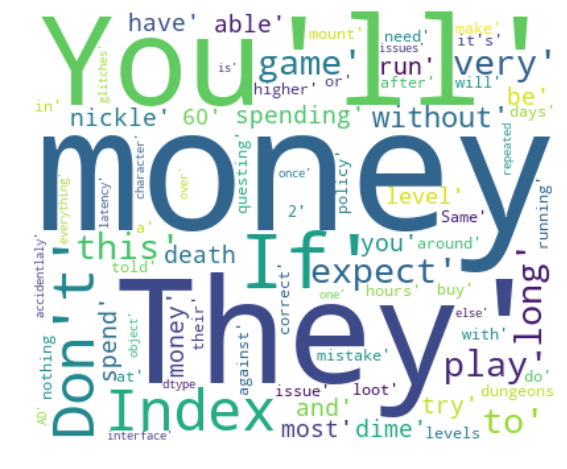

In [85]:
fdist = FreqDist(data['user_review'][8000].split())
fdist_df = pd.DataFrame.from_dict(fdist,orient = 'index')
fdist_df.columns = ['Frequency']
#fdist_df
wc = WordCloud(width=400, height=330, max_words=1000, background_color='white').generate(str(fdist_df.index))

plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

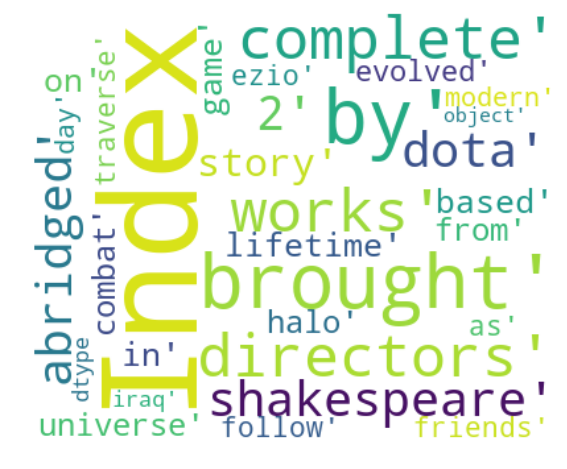

In [89]:
fdist = FreqDist(data['user_review_clean'][1900].split())
fdist_df = pd.DataFrame.from_dict(fdist,orient = 'index')
fdist_df.columns = ['Frequency']
#fdist_df
wc = WordCloud(width=400, height=330, max_words=1000, background_color='white').generate(str(fdist_df.index))

plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [73]:
# preprocess the texts

def _clean(txt) :
    
    lem = WordNetLemmatizer()
    txt = txt.lower()
    #txt =  txt.replace(' ', '')
    txt = re.sub(r'[^a-zA-Z0-9]+',' ',txt)
    #txt = txt.replace('[^\w\s]','')
    punctuations  = string.punctuation
    txt = ''.join(c for c in txt if c not in punctuations)
    
    words = txt.split()
   
    words = [lem.lemmatize(word) for word in words]
    #words = [lem.lemmatize(word, "n") for word in words]
    
    text = " ".join(words)
    
    #words = ' '.join(w for w in words if w not in stopw)
    txt = ' '.join(w for w in txt.split() if not w in stopw)
    txt = ' '.join(w for w in txt.split() if not w in ' ')
    return txt

In [74]:
data['user_review_clean'] = data['user_review'].apply(lambda x : _clean(x))

C:\Users\Pattabhiraman\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [108]:
data['overview_clean'] = data['overview'].apply(lambda x : _clean(x))

In [51]:
data[['user_review','user_review_clean','overview','overview_clean','user_suggestion']].sample(5)

user_review  \
9641                                                                                                                                                                                                                                                                                                                                                                               People aren't reviewing this game critically enough. As a new player, I can assure you this game contains lots of content to keep you occupied for tens of hundreds of hours. Lots of dungeons, large, open world map, and the game is still being developed. Don't listen to these greedy reviewers. The game is really fun and enjoyable!EDIT: EVERYONE WRITE REVIEWS IF YOU WANT FREE VAULT :D   
9423   SCROL DOWN FOR 2017 REVIEWnice and fun game but if you are rich there's a bunch of noobs (scammers) who they give crup for 1 cooler item.I have frost bow. One day someone trades me and he said: i want your frost boy Then i said : okBut he gives me only 1 dexterity pot this wep is 5-6 defence or 2 frost weps (dex pot is only 1 spd 0.5 def)I  recommend this with a yes. But i can say this is a bad and boring game cuz some shiters make this !!!!!!!I HOPE YOU READ MY RECOMMENDATION AND GET YOUR ANSWER DOWNLOAD OR NOT !2017 REVIEW :This is an Ok game but the devs don't care about it they just care about money and if you not put money to get loot is time 10 harder to get good loot than what it was at 2012,2013,2014,2015Also the gameplay is ver...   
16567  After playing around 100 hours with bloonds td 5 and another 100 with bloons monkey city I tried the game and here is my review:Pro's:+It uses the addictive and genious formula of btd5 whitch makes it a fun game+multiple game modes (assault, defense, special gamemodes and the card game)+it can get really satisfying when racing to who survives the later rounds+Healthy gamelenght due to the addictivness of card collecting and the funness of the assault modeCon's:-You will be clueless and you will loose a lot unless you played btd5, so try that first if you can-Camo led ballon's wrecking new players because they don't know how to counter it-Somewhat pay to win, new players only get standart towers and have to unlock the rest-A lot of noob ...   
2009                                                                                                                                                                                                                                                                                                     ░░░░░░░░▄▄▄▀▀▀▄▄███▄░░░░░░░░░░░░░░░░░░░░░░▄▀▀░░░░░░░▐░▀██▌░░░░░░░░░░░░░░░░ ░░░▄▀░░░░▄▄███░▌▀▀░▀█░░░░░░░░░░░░░░░░ ░░▄█░░▄▀▀▒▒▒▒▒▄▐░░░░█▌░░░░░░░░░░░░░░░ ░▐█▀▄▀▄▄▄▄▀▀▀▀▌░░░░░▐█▄░░░░░░░░░░░░░░ ░▌▄▄▀▀░░░░░░░░▌░░░░▄███████▄░░░░░░░░░ ░░░░░░░░░░░░░▐░░░░▐███████████▄░░░░░░ ░░░░░le░░░░░░░▐░░░░▐█████████████▄░░░░░░░░toucan░░░░░░▀▄░░░▐██████████████▄░░░░░░░░has░░░░░░░░▀▄▄████████████████▄░ ░░░░░arrived░░░░░░░░░░░░█▀██████░░░░░░░░THERE CAN ONLY BE ONE TRUE GOD, EXILE.   
13622                                                                                                                                                                                                                                                                                                                                                                                                                                                            Early Access ReviewThis game is a good alternative to Minecraft, i really like it that you don't need to setup your own server and that it is free to play for everybody, this makes it very easy to play with friends that want to try the game.The only thing i really miss are community built addons and mods.    

                                                                                                                                                                                        

In [92]:
all_pos_words = data['user_review_clean'][1600].split()
freqdistpos = FreqDist(all_pos_words)
print(freqdistpos.most_common(500))

[('i', 8), ('in', 6), ('but', 6), ('like', 5), ('good', 4), ('it', 3), ('gameplay', 3), ('really', 3), ('d', 3), ('see', 3), ('with', 3), ('are', 3), ('early', 2), ('access', 2), ('what', 2), ('while', 2), ('that', 2), ('so', 2), ('these', 2), ('yet', 2), ('game', 2), ('out', 2), ('more', 2), ('m', 2), ('thats', 2), ('its', 2), ('reviewfrom', 1), ('ve', 1), ('played', 1), ('not', 1), ('heap', 1), ('can', 1), ('definatly', 1), ('say', 1), ('yes', 1), ('development', 1), ('even', 1), ('still', 1), ('provides', 1), ('challenging', 1), ('mechanic', 1), ('isnt', 1), ('seen', 1), ('games', 1), ('days', 1), ('controling', 1), ('massive', 1), ('ships', 1), ('difficult', 1), ('somehow', 1), ('simple', 1), ('using', 1), ('weapons', 1), ('breeze', 1), ('takes', 1), ('influences', 1), ('from', 1), ('third', 1), ('person', 1), ('shooters', 1), ('aim', 1), ('then', 1), ('click', 1), ('on', 1), ('top', 1), ('managing', 1), ('everything', 1), ('making', 1), ('stratagy', 1), ('win', 1), ('match', 1), (

In [93]:
freqdistpos

FreqDist({'i': 8, 'in': 6, 'but': 6, 'like': 5, 'good': 4, 'it': 3, 'gameplay': 3, 'really': 3, 'd': 3, 'see': 3, ...})

In [53]:
tags = nltk.pos_tag(nltk.word_tokenize(data['user_review_clean'][1000]))
tags

[('an', 'DT'),
 ('excellent', 'JJ'),
 ('variety', 'NN'),
 ('of', 'IN'),
 ('ships', 'NNS'),
 ('with', 'IN'),
 ('different', 'JJ'),
 ('playstyles', 'NNS'),
 ('i', 'VBP'),
 ('don', 'VBP'),
 ('t', 'JJ'),
 ('play', 'VBP'),
 ('a', 'DT'),
 ('lot', 'NN'),
 ('of', 'IN'),
 ('space', 'NN'),
 ('combat', 'NN'),
 ('games', 'NNS'),
 ('but', 'CC'),
 ('the', 'DT'),
 ('tutorial', 'JJ'),
 ('leads', 'NN'),
 ('you', 'PRP'),
 ('through', 'IN'),
 ('nicely', 'RB'),
 ('and', 'CC'),
 ('the', 'DT'),
 ('space', 'NN'),
 ('comabt', 'NN'),
 ('met', 'VBD'),
 ('my', 'PRP$'),
 ('expectations', 'NNS'),
 ('of', 'IN'),
 ('what', 'WP'),
 ('space', 'NN'),
 ('combat', 'NN'),
 ('should', 'MD'),
 ('feel', 'VB'),
 ('like', 'IN'),
 ('great', 'JJ'),
 ('hulking', 'VBG'),
 ('ships', 'NNS'),
 ('with', 'IN'),
 ('a', 'DT'),
 ('massive', 'JJ'),
 ('array', 'NN'),
 ('of', 'IN'),
 ('beam', 'NN'),
 ('and', 'CC'),
 ('laser', 'NN'),
 ('canons', 'NNS'),
 ('and', 'CC'),
 ('smaller', 'JJR'),
 ('more', 'RBR'),
 ('mobile', 'JJ'),
 ('ships', 'NNS'

In [285]:
all_pos_words = data['user_review_clean'][340]
txtblobobj = TextBlob(all_pos_words )
txtblobobj.sentiment,data['user_suggestion'][340]

(Sentiment(polarity=0.013737373737373734, subjectivity=0.5628282828282828), 1)

In [94]:
data['review_polarity']     = data['user_review_clean'].apply(lambda x : TextBlob(x).sentiment[0])
data['review_subjectivity'] = data['user_review_clean'].apply(lambda x : TextBlob(x).sentiment[1])

In [151]:
data['overview_polarity']     = data['overview_clean'].apply(lambda x : TextBlob(x).sentiment[0])
data['overview_subjectivity'] = data['overview_clean'].apply(lambda x : TextBlob(x).sentiment[1])

In [95]:
data[data.review_polarity >0].shape[0],data[data.review_polarity <0].shape[0]

(11238, 6058)

In [98]:
11238/17296, 6058/17296

(0.6497456059204441, 0.35025439407955594)

In [99]:
def revkeywords(text) :
    selfam = ['RB','JJ','NNS','NN','IN','DT','CD','VB','VBZ']
    txt = []
    tags = nltk.pos_tag(nltk.word_tokenize(text))
    for tag in tags :
        po = tag[1]
        if po in selfam :
            txt.append(tag[0])

    listtostring = ' '.join(str(x) for x in txt)
    return listtostring

In [100]:
data['finer_review'] = data['user_review_clean'].apply(lambda x : revkeywords(x))

In [101]:
data['finer_polarity']     = data['finer_review'].apply(lambda x : TextBlob(x).sentiment[0])
data['finer_subjectivity'] = data['finer_review'].apply(lambda x : TextBlob(x).sentiment[1])

In [102]:
data[data.finer_polarity >0].shape[0],data[data.finer_polarity <0].shape[0]

(9508, 7724)

In [104]:
9508/17232,7724/17232

(0.5517641597028784, 0.44823584029712166)

12186

In [112]:
data[['finer_polarity','user_suggestion']].sample(5)

finer_polarity  user_suggestion
10992       -0.032500                0
10342       -0.038278                1
5642         0.200000                1
2087        -0.023403                1
4452        -0.032143                0

In [119]:
import pickle

with open(r'C:\Users\Pattabhiraman\AVSolutions Folder\NLP Folder\glove.6B.200d.pkl', 'rb') as fp:
    # load glove from disk 
    glove = pickle.load(fp)

In [122]:
glove

{'the': array([-7.1549e-02,  9.3459e-02,  2.3738e-02, -9.0339e-02,  5.6123e-02,
         3.2547e-01, -3.9796e-01, -9.2139e-02,  6.1181e-02, -1.8950e-01,
         1.3061e-01,  1.4349e-01,  1.1479e-02,  3.8158e-01,  5.4030e-01,
        -1.4088e-01,  2.4315e-01,  2.3036e-01, -5.5339e-01,  4.8154e-02,
         4.5662e-01,  3.2338e+00,  2.0199e-02,  4.9019e-02, -1.4132e-02,
         7.6017e-02, -1.1527e-01,  2.0060e-01, -7.7657e-02,  2.4328e-01,
         1.6368e-01, -3.4118e-01, -6.6070e-02,  1.0152e-01,  3.8232e-02,
        -1.7668e-01, -8.8153e-01, -3.3895e-01, -3.5481e-02, -5.5095e-01,
        -1.6899e-02, -4.3982e-01,  3.9004e-02,  4.0447e-01, -2.5880e-01,
         6.4594e-01,  2.6641e-01,  2.8009e-01, -2.4625e-02,  6.3302e-01,
        -3.1700e-01,  1.0271e-01,  3.0886e-01,  9.7792e-02, -3.8227e-01,
         8.6552e-02,  4.7075e-02,  2.3511e-01, -3.2127e-01, -2.8538e-01,
         1.6670e-01, -4.9707e-03, -6.2714e-01, -2.4904e-01,  2.9713e-01,
         1.4379e-01, -1.2325e-01, -5.8178e-0

In [125]:
len(glove)

176867

In [58]:
from gensim.utils import simple_preprocess
print(len(simple_preprocess(data['user_review'][13252])))

778


In [124]:
from gensim.utils import simple_preprocess
print(simple_preprocess(data['user_review_clean'][78]))

['hi', 'all', 'reading', 'this', 'wonderful', 'review', 'after', 'playing', 'this', 'game', 'approxomitely', 'hours', 'with', 'group', 'friends', 'we', 'attained', 'lot', 'information', 'opinions', 'on', 'game', 'we', 'myself', 'will', 'big', 'nips', 'alfiethelad', 'archibald', 'crotch', 'robinson', 'sam', 'key', 'smurph', 'suicidal', 'some', 'gay', 'decided', 'spice', 'night', 'up', 'play', 'this', 'game', 'as', 'drinking', 'game', 'we', 'finished', 'game', 'ye', 'ending', 'we', 'drank', 'every', 'jump', 'scare', 'ye', 'big', 'nips', 'got', 'very', 'drunk', 'threw', 'up', 'we', 'finished', 'game', 'ye', 'ending', 'previously', 'mentioned', 'but', 'it', 'was', 'very', 'anyway', 'pretty', 'scary', 'fun', 'archie', 'gay', 'would', 'play', 'again', 'would', 'recommend', 'friend', 'ty', 'bby', 'would', 'deffo', 'reccomend']


In [126]:
from gensim.utils import simple_preprocess
user_review_pp= data['user_review_clean'].apply(lambda x :simple_preprocess(x))
tags_pp = data['tags_str'].apply(lambda x :simple_preprocess(x))
#overview_pp = data['overview_clean'].apply(lambda x : simple_preprocess(x))

KeyError: 'overview_clean'

In [127]:
user_review_pp.shape

(17494,)

In [128]:
data.columns

Index(['title', 'year', 'developer', 'publisher', 'tags', 'tags_str',
       'user_review', 'user_suggestion', 'overview', 'user_review_clean',
       'review_polarity', 'review_subjectivity', 'finer_review',
       'finer_polarity', 'finer_subjectivity'],
      dtype='object')

In [129]:
train_X.columns

Index(['review_id', 'title', 'year', 'user_review', 'user_suggestion',
       'developer', 'publisher', 'tags', 'overview', 'tags_str', 'tags_count'],
      dtype='object')

In [143]:
ind = []
for i in range(len(user_review_pp)) :
    if user_review_pp[i] == [] :
        ind.append(i)
for i in ind :
    if train_X.iloc[i,4] == 1 :
        data.iloc[i,9] = 'excellent'
    elif train_X.iloc[i,4] == 0 :
        data.iloc[i,9] = 'poor'
data.shape       

(17494, 15)

In [144]:
ind

[]

In [134]:
ind = []
for i in range(len(overview_pp)) :
    if overview_pp[i] == [] :
        ind.append(i)
for i in ind :
    if train_X.iloc[i,4] == 1 :
        data.iloc[i,10] = 'excellent'
    elif train_X.iloc[i,4] == 0 :
        data.iloc[i,10] = 'poor'
data.shape

(17494, 12)

In [135]:
i

16524

In [132]:
user_review_pp= data['user_review_clean'].apply(lambda x :simple_preprocess(x))

In [136]:
overview_pp= data['overview_clean'].apply(lambda x :simple_preprocess(x))

In [117]:
len(user_review_pp)

17494

In [260]:
train['user_review'][4035],train['user_suggestion'][4035]

('За те деньги , что ты сюда вложил ты мог купить овервотч и получать удовольствие от игры  вместо чувства , что 4 оставшихся человека , которые работают над этой игрой явно не справляются.',
 1)

In [119]:
from gensim.models import Word2Vec
# train a word2vec model from the given data set
w2v_model1 = Word2Vec(tags_pp, size=300, min_count=2, sg=1)

In [137]:
from gensim.models import Word2Vec
# train a word2vec model from the given data set
w2v_model2 = Word2Vec(overview_pp, size=300, min_count=2, sg=1)

In [181]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(user_review_pp, size=300, min_count=2, sg=1)

In [182]:
len(w2v_model.wv.vocab),len(w2v_model1.wv.vocab),len(w2v_model2.wv.vocab)

(21861, 167, 2843)

In [319]:
w2v_model

In [320]:
list(w2v_model.wv.vocab.items())[77]

('can', <gensim.models.keyedvectors.Vocab at 0x2b892db7b38>)

In [151]:
print('shape of \'warning\' vector:', w2v_model.wv.get_vector('warning').shape)

shape of 'warning' vector: (300,)


In [141]:
# returns vector reperesentation of a given word if it is present in vocabulary
import math
def get_embedding_w2v(doc_tokens, pre_trained):
    embeddings = []
    # if pre_trained = 1; use Google's model else use our own model
    if pre_trained:
        model = glove
    else:
        model = w2v_model
    # iterate over tokens to extract their vectors    
    for tok in doc_tokens:
        if pre_trained:                       
            if tok in model:
                embeddings.append(model[tok])
        else:
            if tok in model.wv.vocab:
                embeddings.append(model.wv.word_vec(tok))
    
    # mean the vectors of individual words to get the vector of the statement
    
    return np.mean(embeddings, axis=0)

In [110]:
X_w2v_model = np.delete(X_w2v_model,77,axis =0)

ValueError: Length of passed values is 17493, index implies 17494

In [134]:
for i in range(len(user_review_pp)) :
    if user_review_pp[i] == [] :
        print(i)
    

In [138]:
for i in range(len(overview_pp)) :
    if overview_pp[i] == [] :
        print(i)
    

In [161]:
train_X.iloc[9515,4]

0

In [132]:
X_w2v_model1 = tags_pp.apply(lambda x: get_embedding_w2v(x, pre_trained=0))
X_w2v_model1 = pd.DataFrame(X_w2v_model1.tolist())
print('X shape:', X_w2v_model1.shape)
X_w2v_model1

X shape: (17494, 300)


0         1         2         3         4         5         6    \
0     -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
1     -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
2     -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
3     -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
4     -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
5     -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
6     -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
7     -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
8     -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
9     -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
10    -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
11    -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
12    -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
13    -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
14    -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
15    -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
16    -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
17    -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
18    -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
19    -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
20    -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
21    -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
22    -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
23    -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
24    -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
25    -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
26    -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
27    -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
28    -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
29    -0.047418  0.063482  0.007095  0.110909 -0.119732 -0.016004  0.265820   
...         ...       ...       ...       ...       ...       ...       ...   
17464 -0.037511  0.077471 -0.032425  0.131332 -0.146485  0.022043  0.270775   
17465 -0.037511  0.077471 -0.032425  0.131332 -0.146485  0.022043  0.270775   
17466 -0.037511  0.077471 -0.032425  0.131332 -0.146485  0.022043  0.270775   
17467 -0.037511  0.077471 -0.032425  0.131332 -0.146485  0.022043  0.270775   
17468 -0.037511  0.077471 -0.032425  0.131332 -0.146485  0.022043  0.270775   
17469 -0.037511  0.077471 -0.032425  0.131332 -0.146485  0.022043  0.270775   
17470 -0.037511  0.077471 -0.032425  0.131332 -0.146485  0.022043  0.270775   
17471 -0.037511  0.077471 -0.032425  0.131332 -0.146485  0.022043  0.270775   
17472 -0.037511  0.077471 -0.032425  0.131332 -0.146485  0.022043  0.270775   
17473 -0.037511  0.077471 -0.032425  0.131332 -0.146485  0.022043  0.270775   
17474 -0.037511  0.077471 -0.032425  0.131332 -0.146485  0.022043  0.270775   
17475 -0.037511  0.077471 -0.032425  0.131332 -0.146485  0.022043  0.270775   
17476 -0.037511  0.077471 -0.032425  0.131332 -0.146485  0.022043  0.270775   
17477 -0.037511  0.077471 -0.032425  0.131332 -0.146485  0.022043  0.270775   
17478 -0.037511  0.077471 -0.032425  0.131332 -0.146485  0.022043  0.270775   
17479 -0.037511  0.077471 -0.032425  0.131332 -0.146485  0.022043  0.270775   
17480 -0.037511  0.077471 -0.032425  0.131332 -0.146485  0.022043  0.270775   
17481 -0.037511  0.077471 -0.032425  0.131332 -0.146485  0.022043  0.270775   
17482 -0.037511  0.077471 -0.032425  0.131332 -0.146485  0.022

In [139]:
X_w2v_model2 = overview_pp.apply(lambda x: get_embedding_w2v(x, pre_trained=0))
X_w2v_model2 = pd.DataFrame(X_w2v_model2.tolist())
print('X shape:', X_w2v_model2.shape)
X_w2v_model2

X shape: (17494, 300)


0         1         2         3         4         5         6    \
0      0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
1      0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
2      0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
3      0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
4      0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
5      0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
6      0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
7      0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
8      0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
9      0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
10     0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
11     0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
12     0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
13     0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
14     0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
15     0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
16     0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
17     0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
18     0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
19     0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
20     0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
21     0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
22     0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
23     0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
24     0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
25     0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
26     0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
27     0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
28     0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
29     0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
...         ...       ...       ...       ...       ...       ...       ...   
17464 -0.013818  0.093555  0.012935  0.075535 -0.026941  0.027170  0.138113   
17465 -0.013818  0.093555  0.012935  0.075535 -0.026941  0.027170  0.138113   
17466 -0.013818  0.093555  0.012935  0.075535 -0.026941  0.027170  0.138113   
17467 -0.013818  0.093555  0.012935  0.075535 -0.026941  0.027170  0.138113   
17468 -0.013818  0.093555  0.012935  0.075535 -0.026941  0.027170  0.138113   
17469 -0.013818  0.093555  0.012935  0.075535 -0.026941  0.027170  0.138113   
17470 -0.013818  0.093555  0.012935  0.075535 -0.026941  0.027170  0.138113   
17471 -0.013818  0.093555  0.012935  0.075535 -0.026941  0.027170  0.138113   
17472 -0.013818  0.093555  0.012935  0.075535 -0.026941  0.027170  0.138113   
17473 -0.013818  0.093555  0.012935  0.075535 -0.026941  0.027170  0.138113   
17474 -0.013818  0.093555  0.012935  0.075535 -0.026941  0.027170  0.138113   
17475 -0.013818  0.093555  0.012935  0.075535 -0.026941  0.027170  0.138113   
17476 -0.013818  0.093555  0.012935  0.075535 -0.026941  0.027170  0.138113   
17477 -0.013818  0.093555  0.012935  0.075535 -0.026941  0.027170  0.138113   
17478 -0.013818  0.093555  0.012935  0.075535 -0.026941  0.027170  0.138113   
17479 -0.013818  0.093555  0.012935  0.075535 -0.026941  0.027170  0.138113   
17480 -0.013818  0.093555  0.012935  0.075535 -0.026941  0.027170  0.138113   
17481 -0.013818  0.093555  0.012935  0.075535 -0.026941  0.027170  0.138113   
17482 -0.013818  0.093555  0.012935  0.075535 -0.026941  0.027

In [137]:
# create X from w2vec
X_w2v_model = user_review_pp.apply(lambda x: get_embedding_w2v(x, pre_trained=0))
X_w2v_model = pd.DataFrame(X_w2v_model.tolist())
print('X shape:', X_w2v_model.shape)
X_w2v_model

NameError: name 'w2v_model' is not defined

In [142]:
# create X from w2vec
X_w2v_model = user_review_pp.apply(lambda x: get_embedding_w2v(x, pre_trained=1))
X_w2v_model = pd.DataFrame(X_w2v_model.tolist())
print('X shape:', X_w2v_model.shape)
X_w2v_model

C:\Users\Pattabhiraman\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


TypeError: 'numpy.float64' object is not iterable

In [185]:
data.columns

Index(['title', 'year', 'developer', 'publisher', 'tags', 'tags_str',
       'user_review', 'user_suggestion', 'overview', 'user_review_clean',
       'overview_clean', 'finer_review', 'overview_polarity',
       'overview_subjectivity', 'finer_polarity', 'finer_subjectivity',
       'review_polarity', 'review_subjectivity'],
      dtype='object')

In [186]:
mdata1 = data[['title','year','developer','publisher','overview_polarity','review_polarity']]
mdata2 = train_X['tags_count']

In [187]:
model = pd.concat([X_w2v_model2,X_w2v_model,X_w2v_model,mdata1,mdata2],axis=1)
model.shape

(17494, 907)

In [188]:
model.head()

0         1         2         3         4         5         6  \
0  0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
1  0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
2  0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
3  0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   
4  0.005589  0.144764  0.051337  0.052557  0.016009  0.005694  0.139649   

         7         8        9  ...       297       298       299  title  \
0  0.04925 -0.011884  0.15372  ... -0.043905  0.148497  0.073756     33   
1  0.04925 -0.011884  0.15372  ... -0.130143  0.124761  0.074530     33   
2  0.04925 -0.011884  0.15372  ... -0.075565  0.162355  0.067093     33   
3  0.04925 -0.011884  0.15372  ... -0.053468  0.148086  0.054402     33   
4  0.04925 -0.011884  0.15372  ... -0.085899  0.159526  0.110305     33   

     year  developer  publisher  overview_polarity  review_polarity  \
0  2016.0         18         21            0.28322        -0.028125   
1  2016.0         18         21            0.28322         0.090000   
2  2016.0         18         21            0.28322         0.011374   
3  2015.0         18         21            0.28322         0.333333   
4  2015.0         18         21            0.28322         0.045408   

   tags_count  
0          20  
1          20  
2          20  
3          20  
4          20  

[5 rows x 907 columns]

In [189]:
y = data['user_suggestion'].values
X_train,X_val,y_train,y_val = train_test_split(model,y,test_size = .30,random_state = 11,shuffle= True,stratify = y)

In [190]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_train.shape

(12245, 907)

In [171]:
# try with countvectorizer 

cvz = CountVectorizer(max_features = 2500,binary=True,stop_words = stopw)
cvz.fit(data['user_review_clean'].values)
count_vectors = cvz.transform(data['user_review_clean'].values)
count_vectors

<17494x2500 sparse matrix of type '<class 'numpy.int64'>'
	with 1137975 stored elements in Compressed Sparse Row format>

In [71]:
tag_tfidf = TfidfVectorizer(analyzer ='word') 
tag_tfidf.fit(gameov['tags_str'].values)
tag_vector_tfidf = tag_tfidf.transform(data['tags_str'].values)

In [72]:
tag_vector_tfidf

<17494x185 sparse matrix of type '<class 'numpy.float64'>'
	with 408891 stored elements in Compressed Sparse Row format>

In [414]:
word_tfidf = TfidfVectorizer(max_features = 2500,binary = True,stop_words = stopw,min_df = 5,max_df = 0.80,analyzer = 'word',ngram_range=(1,3)) 
word_tfidf.fit(data['overview_clean'].values)
word_vector_tfidf = word_tfidf.transform(data['overview_clean'].values)

In [149]:
word_tfidf = TfidfVectorizer(max_features = 2000,stop_words = stop_words,min_df = 5,max_df = 0.80,analyzer = 'word') 
word_tfidf.fit(data['user_review_clean'].values)
word_vector_tfidf1 = word_tfidf.transform(data['user_review_clean'].values)

In [296]:
word_tfidf = TfidfVectorizer(max_features = 2500,binary = True,stop_words = stopw,min_df = 5,max_df = 0.80,analyzer = 'word',ngram_range=(1,3)) 
word_tfidf.fit(data['finer_review'].values)
word_vector_tfidf2 = word_tfidf.transform(data['finer_review'].values)

In [172]:
meta_features = ['title','year','developer','publisher','tags_count']
feature_set1 = data[meta_features]
X = hstack([count_vectors,tags_rs,csr_matrix(feature_set1)],"csr")
y = data['user_suggestion'].values

In [297]:
meta_features = ['title','year','developer','publisher','tags_count']
feature_set1 = data[meta_features]
X = hstack([word_vector_tfidf2,tags_rs,csr_matrix(feature_set1)],"csr")
y = data['user_suggestion'].values

In [150]:
meta_features = ['title','year','developer','publisher','tags_count']
feature_set1 = data[meta_features]
X = hstack([word_vector_tfidf1,tag_vector_tfidf,csr_matrix(feature_set1)],"csr")
y = data['user_suggestion'].values

In [65]:
data.columns

Index(['title', 'year', 'developer', 'publisher', 'tags', 'tags_str',
       'tags_count', 'user_review', 'overview', 'user_suggestion',
       'user_review_clean'],
      dtype='object')

In [381]:
meta_features = ['title','year','developer','publisher','tags_count','review_polarity', 'review_subjectivity',
               'overview_polarity', 'overview_subjectivity', 'finer_polarity', 'finer_subjectivity']

feature_set1 = data[meta_features]
X =  hstack([word_vector_tfidf2,csr_matrix(feature_set1)],"csr")
y = data['user_suggestion'].values

In [151]:
X.shape,y.shape

((17494, 2190), (17494,))

In [152]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = .30,random_state = 11,shuffle= True,stratify = y)

In [393]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_val_scale   = scaler.transform(X_val)

In [202]:
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)
X_val_scale   = scaler.transform(X_val)

In [192]:
for C in [0.001,0.05,0.01,0.50,1] :
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train,y_train)
    prediction = logistic_model.predict(X_val)
    print(C,f1_score(y_val,prediction))

C:\Users\Pattabhiraman\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.001 0.8667214461791289


C:\Users\Pattabhiraman\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.05 0.8667214461791289


C:\Users\Pattabhiraman\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.01 0.8667214461791289


C:\Users\Pattabhiraman\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5 0.8667214461791289


C:\Users\Pattabhiraman\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1 0.8667214461791289


In [207]:
naive_bayes_model = naive_bayes.GaussianNB(var_smoothing=1e-05)
naive_bayes_model.fit(X_train_scale,y_train)

GaussianNB(priors=None, var_smoothing=1e-05)

In [325]:
support_vector_model = svm.SVC(degree =6)
support_vector_model.fit(X_train,y_train)

C:\Users\Pattabhiraman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=6, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [159]:
linear_support_model = LinearSVC(random_state = 11,tol =1e5)
linear_support_model.fit(X_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=11, tol=100000.0,
     verbose=0)

In [195]:
xgb_model = xgboost.XGBClassifier(n_estimators = 100,max_depth = 5,learning_rate = 0.01)
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.01,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [197]:
knn_model = KNeighborsClassifier(n_neighbors = 6)
knn_model.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='uniform')

In [198]:
random_forest_model = RandomForestClassifier(n_estimators = 100, max_depth = 3,random_state =11)
random_forest_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=11, verbose=0, warm_start=False)

In [199]:
def classifierprediction(classifier,model,X_valtst,y_val) :
    prediction = classifier.predict(X_valtst)
    if y_val != '' :
        f1s = f1_score(y_val,prediction,average = 'binary')
        print("f1 score from " + model + ' ', f1s)
        print(classification_report(y_val,prediction))
    return prediction

In [200]:
lrp =  classifierprediction(logistic_model,'Logistic Regression',X_val,y_val)

f1 score from Logistic Regression  0.8667214461791289
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      2258
           1       0.85      0.88      0.87      2991

   micro avg       0.85      0.85      0.85      5249
   macro avg       0.84      0.84      0.84      5249
weighted avg       0.85      0.85      0.84      5249



C:\Users\Pattabhiraman\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


In [208]:
nbp = classifierprediction(naive_bayes_model,'naive bayes',X_val_scale,y_val)

f1 score from naive bayes  0.4937062937062937
              precision    recall  f1-score   support

           0       0.51      0.89      0.65      2258
           1       0.82      0.35      0.49      2991

   micro avg       0.59      0.59      0.59      5249
   macro avg       0.66      0.62      0.57      5249
weighted avg       0.68      0.59      0.56      5249



C:\Users\Pattabhiraman\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


In [330]:
svp =  classifierprediction(support_vector_model,'Support Vector',X_val,y_val)

f1 score from Support Vector  0.7259708737864078
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2258
           1       0.57      1.00      0.73      2991

   micro avg       0.57      0.57      0.57      5249
   macro avg       0.28      0.50      0.36      5249
weighted avg       0.32      0.57      0.41      5249



C:\Users\Pattabhiraman\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Pattabhiraman\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [209]:
xgp = classifierprediction(xgb_model,'XGBoost',X_val,y_val)

f1 score from XGBoost  0.8470663674254569
              precision    recall  f1-score   support

           0       0.83      0.73      0.78      2258
           1       0.81      0.88      0.85      2991

   micro avg       0.82      0.82      0.82      5249
   macro avg       0.82      0.81      0.81      5249
weighted avg       0.82      0.82      0.82      5249



C:\Users\Pattabhiraman\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


In [210]:
knp = classifierprediction(knn_model,'KNN',X_val,y_val)

f1 score from KNN  0.8304969366916269
              precision    recall  f1-score   support

           0       0.77      0.80      0.78      2258
           1       0.85      0.82      0.83      2991

   micro avg       0.81      0.81      0.81      5249
   macro avg       0.81      0.81      0.81      5249
weighted avg       0.81      0.81      0.81      5249



C:\Users\Pattabhiraman\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


In [171]:
lsp =  classifierprediction(linear_support_model,'Linear Support Vector',X_val,y_val)

f1 score from Linear Support Vector  0.7321788159484495
              precision    recall  f1-score   support

           0       0.64      0.93      0.76      2256
           1       0.92      0.61      0.73      2982

   micro avg       0.75      0.75      0.75      5238
   macro avg       0.78      0.77      0.75      5238
weighted avg       0.80      0.75      0.74      5238



C:\Users\Pattabhiraman\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


In [211]:
rfp =  classifierprediction(random_forest_model,'Random Forest',X_val,y_val)

f1 score from Random Forest  0.8171728971962616
              precision    recall  f1-score   support

           0       0.86      0.53      0.66      2258
           1       0.73      0.94      0.82      2991

   micro avg       0.76      0.76      0.76      5249
   macro avg       0.79      0.73      0.74      5249
weighted avg       0.78      0.76      0.75      5249



C:\Users\Pattabhiraman\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


In [212]:
# processing the test file
test = pd.read_csv('test.csv')
test.head()

review_id                             title    year  \
0       1603  Counter-Strike: Global Offensive  2015.0   
1       1604  Counter-Strike: Global Offensive  2018.0   
2       1605  Counter-Strike: Global Offensive  2018.0   
3       1606  Counter-Strike: Global Offensive  2015.0   
4       1607  Counter-Strike: Global Offensive  2015.0   

                                         user_review  
0  Nice graphics, new maps, weapons and models. B...  
1  I would not recommend getting into this at its...  
2  Edit 11/12/18I have tried playing CS:GO recent...  
3  The game is great. But the community is the wo...  
4  I thank TrulyRazor for buying this for me a lo...

In [213]:
test.shape

(8045, 4)

In [214]:
test.isnull().sum()

review_id       0
title           0
year           67
user_review     0
dtype: int64

In [215]:
# Reviews present from 2011 till 2018
test['year'].min(),test['year'].max()

(2011.0, 2018.0)

In [216]:
# check year wise user suggestion counts
test.groupby(test['year']).count()

review_id  title  user_review
year                                 
2011.0         55     55           55
2012.0         75     75           75
2013.0        120    120          120
2014.0        522    522          522
2015.0       1314   1314         1314
2016.0       2502   2502         2502
2017.0       2161   2161         2161
2018.0       1229   1229         1229

In [217]:
# number of unique titles in the test set
test['title'].nunique()

20

In [218]:
# number of reviews per title

test.groupby(['title']).count()

review_id  year  user_review
title                                                         
Aura Kingdom                            324   322          324
Champions Online                        383   378          383
Counter-Strike: Global Offensive        463   463          463
Crush Crush                             333   329          333
Digimon Masters Online                  310   308          310
Dungeon Defenders II                    554   552          554
Fishing Planet                          498   496          498
GUNS UP!                                 77    76           77
Governor of Poker 3                      89    83           89
H1Z1                                    425   422          425
Magic Duels                             893   890          893
Minion Masters                          401   392          401
Paladins®                               529   524          529
Shadowverse CCG                         450   446          450
Shakes and Fidget                       137   136          137
Star Trek Online                        566   564          566
The Lord of the Rings Online™           439   437          439
Tree of Savior (English Ver.)           635   634          635
VEGA Conflict                           173   172          173
World of Warships                       366   354          366

In [219]:
test.year[test.title == 'Aura Kingdom'].unique()

array([2014., 2017., 2015., 2016., 2018.,   nan])

In [220]:
test.year[test.title == 'World of Warships'].unique()

array([2017., 2018.,   nan])

In [221]:
test.year[test.title == 'Minion Masters'].unique()

array([2017., 2016., 2018.,   nan])

In [222]:
# imputing the missing value with year 2017 as the trend is increase in reviews each year
# and in 2017 there was a slight dip
test1 = test.fillna(2017)

In [223]:
test1['title']     = le.fit_transform(test1['title'])

In [224]:
# merge the train and game overview dataset
test_X = pd.merge(test1,gameov,how ='inner',left_on = 'title',right_on = 'title')

In [225]:
# number of unique titles in the test set
test_X['title'].nunique()

20

In [226]:
test_X.dtypes

review_id        int64
title            int32
year           float64
user_review     object
developer        int32
publisher        int32
tags            object
overview        object
tags_str        object
dtype: object

In [227]:
test_X.isnull().sum()

review_id      0
title          0
year           0
user_review    0
developer      0
publisher      0
tags           0
overview       0
tags_str       0
dtype: int64

In [228]:
test_X['tags_count'] =  test_X['tags'].apply(lambda x : len(x))

In [229]:
#test_X['tags'] = test_X['tags'].apply(lambda x : remquotesstr(x) )

In [230]:
test_X['tags'].sample(5)

5691    [Free to Play, Tower Defense, Multiplayer, Str...
530     [Free to Play, Card Game, Strategy, Trading Ca...
7414    [Early Access, Free to Play, RPG, Massively Mu...
7805    [Free to Play, Survival, Open World, Multiplay...
3325    [Free to Play, Anime, Sexual Content, Nudity, ...
Name: tags, dtype: object

In [289]:
# transform target variable ("Tags")
tags_rst = multilabel_binarizer.transform(test_X['tags'])

NameError: name 'multilabel_binarizer' is not defined

In [290]:
tags_rst.shape

NameError: name 'tags_rst' is not defined

In [361]:
#test_X['title']     = le.fit_transform(test_X['title'])
#test_X['developer'] = le.fit_transform(test_X['developer'])
#test_X['publisher'] = le.fit_transform(test_X['publisher'])

In [231]:
test_X['overview_clean'] = test_X['overview'].apply(lambda x : _clean(x))

In [232]:
test_X['user_review_clean'] = test_X['user_review'].apply(lambda x : _clean(x))

In [ ]:
test_X[['user_review','user_review_clean','overview','overview_clean']].sample(5)

In [233]:
test_X['review_polarity']     = test_X['user_review_clean'].apply(lambda x : TextBlob(x).sentiment[0])
test_X['review_subjectivity'] = test_X['user_review_clean'].apply(lambda x : TextBlob(x).sentiment[1])

In [234]:
test_X['overview_polarity']     = test_X['overview_clean'].apply(lambda x : TextBlob(x).sentiment[0])
test_X['overview_subjectivity'] = test_X['overview_clean'].apply(lambda x : TextBlob(x).sentiment[1])

In [451]:
test_X['finer_review']       = test_X['user_review_clean'].apply(lambda x : revkeywords(x))
test_X['finer_polarity']     = test_X['finer_review'].apply(lambda x : TextBlob(x).sentiment[0])
test_X['finer_subjectivity'] = test_X['finer_review'].apply(lambda x : TextBlob(x).sentiment[1])

In [235]:
test_X.columns

Index(['review_id', 'title', 'year', 'user_review', 'developer', 'publisher',
       'tags', 'overview', 'tags_str', 'tags_count', 'overview_clean',
       'user_review_clean', 'review_polarity', 'review_subjectivity',
       'overview_polarity', 'overview_subjectivity'],
      dtype='object')

In [239]:
user_review_test_pp= test_X['user_review_clean'].apply(lambda x :simple_preprocess(x))
tags_test_pp = test_X['tags_str'].apply(lambda x :simple_preprocess(x))
overview_test_pp = test_X['overview_clean'].apply(lambda x :simple_preprocess(x))

In [237]:
test_X.shape

(8045, 16)

In [240]:
ind = []
for i in range(len(user_review_test_pp)) :
    if user_review_test_pp[i] == [] :
        ind.append(i)
for i in ind :
    test_X.iloc[i,11] = 'excellent'
    
test_X.shape       

(8045, 16)

In [241]:
ind = []
for i in range(len(overview_test_pp)) :
    if overview_test_pp[i] == [] :
        ind.append(i)
for i in ind :
    test_X.iloc[i,10] = 'excellent'
    
test_X.shape       

(8045, 16)

In [197]:
#ind = []
#for i in range(len(user_review_test_pp)) :
#    if user_review_test_pp[i] == [] :
#        ind.append(i)
#test_X = test_X.drop(ind)
#test_X.shape

(8034, 11)

In [242]:
user_review_test_pp= test_X['user_review_clean'].apply(lambda x :simple_preprocess(x))

In [245]:
overview_test_pp= test_X['overview_clean'].apply(lambda x :simple_preprocess(x))

In [248]:
w2v_model_test = Word2Vec(tags_test_pp, size=300, min_count=2, sg=1)

In [252]:
w2v_model_test1 = Word2Vec(user_review_test_pp, size=300, min_count=2, sg=1)

In [251]:
w2v_model_test2 = Word2Vec(overview_test_pp, size=300, min_count=2, sg=1)

In [253]:
# create X from w2vec
X_w2v_model_test = tags_test_pp.apply(lambda x: get_embedding_w2v(x, pre_trained=0))
X_w2v_model_test = pd.DataFrame(X_w2v_model_test.tolist())
print('X shape:', X_w2v_model_test.shape)
X_w2v_model_test

X shape: (8045, 300)


0         1         2         3         4         5       6    \
0     0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
1     0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
2     0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
3     0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
4     0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
5     0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
6     0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
7     0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
8     0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
9     0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
10    0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
11    0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
12    0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
13    0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
14    0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
15    0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
16    0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
17    0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
18    0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
19    0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
20    0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
21    0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
22    0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
23    0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
24    0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
25    0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
26    0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
27    0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
28    0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
29    0.064581 -0.180287 -0.180071 -0.038410 -0.080823 -0.099194  0.0923   
...        ...       ...       ...       ...       ...       ...     ...   
8015  0.133611 -0.112686 -0.147350 -0.034922 -0.060448 -0.082514  0.1320   
8016  0.133611 -0.112686 -0.147350 -0.034922 -0.060448 -0.082514  0.1320   
8017  0.133611 -0.112686 -0.147350 -0.034922 -0.060448 -0.082514  0.1320   
8018  0.133611 -0.112686 -0.147350 -0.034922 -0.060448 -0.082514  0.1320   
8019  0.133611 -0.112686 -0.147350 -0.034922 -0.060448 -0.082514  0.1320   
8020  0.133611 -0.112686 -0.147350 -0.034922 -0.060448 -0.082514  0.1320   
8021  0.133611 -0.112686 -0.147350 -0.034922 -0.060448 -0.082514  0.1320   
8022  0.133611 -0.112686 -0.147350 -0.034922 -0.060448 -0.082514  0.1320   
8023  0.133611 -0.112686 -0.147350 -0.034922 -0.060448 -0.082514  0.1320   
8024  0.133611 -0.112686 -0.147350 -0.034922 -0.060448 -0.082514  0.1320   
8025  0.133611 -0.112686 -0.147350 -0.034922 -0.060448 -0.082514  0.1320   
8026  0.133611 -0.112686 -0.147350 -0.034922 -0.060448 -0.082514  0.1320   
8027  0.133611 -0.112686 -0.147350 -0.034922 -0.060448 -0.082514  0.1320   
8028  0.133611 -0.112686 -0.147350 -0.034922 -0.060448 -0.082514  0.1320   
8029  0.133611 -0.112686 -0.147350 -0.034922 -0.060448 -0.082514  0.1320   
8030  0.133611 -0.112686 -0.147350 -0.034922 -0.060448 -0.082514  0.1320   
8031  0.133611 -0.112686 -0.147350 -0.034922 -0.060448 -0.082514  0.1320   
8032  0.133611 -0.112686 -0.147350 -0.034922 -0.060448 -0.082514  0.1320   
8033  0.133611 -0.112686 -0.147350 -0.034922 -0.060448 -0.082514  0.1320   
8034  0.133611 -0.112686 -0.147350 -0.034922 -0.060448 -0.082514  0.1320   
8035  0.133611 -0.112686 -0.147350 -0.034922 -0.060448 -0.0

In [254]:
# create X from w2vec
X_w2v_model_test1 = user_review_test_pp.apply(lambda x: get_embedding_w2v(x, pre_trained=0))
X_w2v_model_test1 = pd.DataFrame(X_w2v_model_test1.tolist())
print('X shape:', X_w2v_model_test1.shape)
X_w2v_model_test1

X shape: (8045, 300)


0         1         2         3         4         5         6    \
0     0.129965  0.049328 -0.106225 -0.070786  0.035456 -0.007605  0.085763   
1     0.129398  0.019344 -0.189058 -0.009713  0.007044 -0.076805  0.040909   
2     0.086397 -0.021590 -0.142588 -0.006410 -0.002944 -0.066486  0.082136   
3     0.099495  0.006353 -0.173612 -0.054166 -0.013231 -0.062562  0.090084   
4     0.106438 -0.019264 -0.151972 -0.024952  0.009759 -0.047440  0.080982   
5     0.109833 -0.012620 -0.140780 -0.041366  0.005551 -0.065476  0.084194   
6     0.081026 -0.005499 -0.160324 -0.034550 -0.012656 -0.079036  0.105817   
7    -0.062307 -0.137768 -0.145280  0.046586 -0.055180 -0.093774  0.120307   
8     0.082860 -0.023948 -0.127548 -0.020486  0.013993 -0.044482  0.068660   
9     0.093076  0.000635 -0.142146 -0.042815 -0.016628 -0.069973  0.071285   
10    0.092820 -0.031274 -0.138474 -0.072550 -0.033896 -0.070394  0.099934   
11   -0.004891 -0.144555 -0.160005  0.052376 -0.041300 -0.064194  0.068189   
12    0.072196 -0.022406 -0.153356 -0.027165 -0.027262 -0.092866  0.124017   
13    0.104151  0.013581 -0.164231 -0.041422 -0.000794 -0.083955  0.091241   
14    0.125986 -0.021136 -0.170349 -0.023401 -0.027482 -0.079961  0.079298   
15    0.060056  0.017995 -0.229197 -0.004778 -0.014711 -0.077253  0.109044   
16    0.093088 -0.002257 -0.167043 -0.055713 -0.010006 -0.050016  0.090873   
17    0.087222 -0.020039 -0.135314 -0.025237 -0.001259 -0.085345  0.101453   
18    0.137541  0.013287 -0.158583 -0.042898 -0.040042 -0.053790  0.107999   
19    0.125451  0.017655 -0.128169 -0.075142 -0.048873 -0.071461  0.096433   
20    0.141132 -0.050738 -0.177485 -0.022784 -0.016316 -0.055836  0.096102   
21    0.137541  0.013287 -0.158583 -0.042898 -0.040042 -0.053790  0.107999   
22    0.108268  0.005805 -0.190152 -0.001937  0.030927 -0.088409  0.075919   
23    0.097568 -0.003845 -0.150513 -0.025607  0.012210 -0.046685  0.076868   
24    0.130885 -0.016270 -0.121052 -0.046044 -0.027130 -0.061049  0.040077   
25    0.051961 -0.003665 -0.112091 -0.028061 -0.014524 -0.091855  0.097395   
26    0.100012  0.002373 -0.164142 -0.039255 -0.004203 -0.062298  0.090273   
27    0.076457  0.015101 -0.154357 -0.058628 -0.031534 -0.097108  0.100885   
28    0.064346 -0.068866 -0.203014 -0.063801 -0.081609 -0.009240  0.088486   
29    0.153218  0.013461 -0.192610 -0.044147  0.025616 -0.029441  0.026645   
...        ...       ...       ...       ...       ...       ...       ...   
8015  0.093080 -0.019010 -0.163722 -0.043663  0.004572 -0.057630  0.106404   
8016  0.133689  0.004319 -0.160497 -0.063859 -0.011956 -0.055373  0.088950   
8017  0.101256 -0.002597 -0.251614 -0.031700 -0.015253 -0.068224  0.093542   
8018  0.107574  0.004670 -0.169216 -0.038969 -0.024641 -0.053807  0.103206   
8019  0.094372  0.023949 -0.175507 -0.046040 -0.011239 -0.069957  0.112213   
8020  0.092944 -0.015698 -0.174026 -0.060069 -0.024485 -0.079654  0.083855   
8021  0.119861 -0.045739 -0.206386 -0.003331 -0.014092 -0.059812  0.086388   
8022  0.067971 -0.043200 -0.219123 -0.037574 -0.004560 -0.096689  0.066405   
8023  0.080643  0.015968 -0.149028 -0.066890 -0.006737 -0.049998  0.098769   
8024  0.102361 -0.030429 -0.131761 -0.039800 -0.012742 -0.060856  0.064715   
8025  0.070150  0.010105 -0.160797 -0.014842 -0.039897 -0.079708  0.114168   
8026  0.093158  0.031315 -0.156101 -0.046790 -0.010466 -0.035853  0.072522   
8027  0.131344 -0.004824 -0.165495 -0.040708 -0.006375 -0.091209  0.051607   
8028  0.086607 -0.011771 -0.180542 -0.028402 -0.003709 -0.091562  0.078056   
8029  0.115855  0.000291 -0.143001 -0.052339 -0.005421 -0.051542  0.087196   
8030  0.096747 -0.022331 -0.152417 -0.043524 -0.014081 -0.056366  0.084754   
8031  0.087298  0.008519 -0.164724 -0.019804 -0.011753 -0.055776  0.081540   
8032  0.069255  0.009066 -0.138698 -0.047533 -0.048546 -0.048632  0.109971   
8033  0.079417 -0.000917 -0.137898 -0.036851 -0.010559 -0.081626  0.082907   
8034  0.072146 -0.006357 -0.13642

In [255]:
# create X from w2vec
X_w2v_model_test2 = overview_test_pp.apply(lambda x: get_embedding_w2v(x, pre_trained=0))
X_w2v_model_test2 = pd.DataFrame(X_w2v_model_test2.tolist())
print('X shape:', X_w2v_model_test2.shape)
X_w2v_model_test2

X shape: (8045, 300)


0         1         2         3         4         5         6    \
0     0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
1     0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
2     0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
3     0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
4     0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
5     0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
6     0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
7     0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
8     0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
9     0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
10    0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
11    0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
12    0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
13    0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
14    0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
15    0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
16    0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
17    0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
18    0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
19    0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
20    0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
21    0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
22    0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
23    0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
24    0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
25    0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
26    0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
27    0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
28    0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
29    0.109325 -0.043776 -0.141901 -0.071174 -0.030474 -0.055846  0.103978   
...        ...       ...       ...       ...       ...       ...       ...   
8015  0.088920 -0.039988 -0.132730 -0.058170 -0.011828 -0.037387  0.091859   
8016  0.088920 -0.039988 -0.132730 -0.058170 -0.011828 -0.037387  0.091859   
8017  0.088920 -0.039988 -0.132730 -0.058170 -0.011828 -0.037387  0.091859   
8018  0.088920 -0.039988 -0.132730 -0.058170 -0.011828 -0.037387  0.091859   
8019  0.088920 -0.039988 -0.132730 -0.058170 -0.011828 -0.037387  0.091859   
8020  0.088920 -0.039988 -0.132730 -0.058170 -0.011828 -0.037387  0.091859   
8021  0.088920 -0.039988 -0.132730 -0.058170 -0.011828 -0.037387  0.091859   
8022  0.088920 -0.039988 -0.132730 -0.058170 -0.011828 -0.037387  0.091859   
8023  0.088920 -0.039988 -0.132730 -0.058170 -0.011828 -0.037387  0.091859   
8024  0.088920 -0.039988 -0.132730 -0.058170 -0.011828 -0.037387  0.091859   
8025  0.088920 -0.039988 -0.132730 -0.058170 -0.011828 -0.037387  0.091859   
8026  0.088920 -0.039988 -0.132730 -0.058170 -0.011828 -0.037387  0.091859   
8027  0.088920 -0.039988 -0.132730 -0.058170 -0.011828 -0.037387  0.091859   
8028  0.088920 -0.039988 -0.132730 -0.058170 -0.011828 -0.037387  0.091859   
8029  0.088920 -0.039988 -0.132730 -0.058170 -0.011828 -0.037387  0.091859   
8030  0.088920 -0.039988 -0.132730 -0.058170 -0.011828 -0.037387  0.091859   
8031  0.088920 -0.039988 -0.132730 -0.058170 -0.011828 -0.037387  0.091859   
8032  0.088920 -0.039988 -0.132730 -0.058170 -0.011828 -0.037387  0.091859   
8033  0.088920 -0.039988 -0.132730 -0.058170 -0.011828 -0.037387  0.091859   
8034  0.088920 -0.039988 -0.13273

In [257]:
mdata1_test = test_X[['title','year','developer','publisher','overview_polarity','review_polarity']]
mdata2_test = test_X['tags_count']

In [258]:
model_test = pd.concat([X_w2v_model_test2,X_w2v_model_test,X_w2v_model_test1,mdata1_test,mdata2_test],axis =1)
model_test.shape

(8045, 907)

In [218]:
cvz = CountVectorizer(max_features = 2500,binary=True,stop_words = stopw)
cvz.fit(test_X['user_review_clean'].values)
count_vectors_test = cvz.transform(test_X['user_review_clean'].values)
count_vectors_test

<8045x2500 sparse matrix of type '<class 'numpy.int64'>'
	with 537998 stored elements in Compressed Sparse Row format>

In [118]:
tag_test_tfidf = TfidfVectorizer(analyzer ='word') 
tag_test_tfidf.fit(gameov['tags_str'].values)
tag_test_vector_tfidf = tag_tfidf.transform(test_X['tags_str'].values)

In [122]:
tag_test_vector_tfidf

<8045x185 sparse matrix of type '<class 'numpy.float64'>'
	with 182559 stored elements in Compressed Sparse Row format>

In [139]:
word_tfidf = TfidfVectorizer(max_features = 5000,stop_words = stopw,min_df = 5,max_df = 0.80,analyzer = 'word') 
word_tfidf.fit(test_X['user_review_clean'].values)
word_vector_tfidf_test = word_tfidf.transform(test_X['user_review_clean'].values)

In [405]:
word_tfidf = TfidfVectorizer(max_features = 1000,min_df = 5,max_df = 0.80,analyzer = 'word') 
word_tfidf.fit(test_X['user_review_clean'].values)
word_vector_tfidf_test1 = word_tfidf.transform(test_X['user_review_clean'].values)

In [452]:
word_tfidf = TfidfVectorizer() 
word_tfidf.fit(test_X['finer_review'].values)
word_vector_tfidf_test2 = word_tfidf.transform(test_X['finer_review'].values)

In [425]:
test_X['finer_review'][0]

'nice graphics new maps weapons models developers listen the customers a bit developers too much on things not important at all focus on the tick rate of the match servers 128 vac a lot those two customers really focus on not stickers ui hud changes skins stop around with the weapons'

In [220]:
meta_features_test = ['title','year','developer','publisher','tags_count']
feature_set1t = test_X[meta_features_test]
X_tst = hstack([count_vectors_test,tags_rst,csr_matrix(feature_set1t)],"csr")

In [140]:
meta_features_test = ['title','year','developer','publisher','tags_count']
feature_set1t = test_X[meta_features_test]
X_tst = hstack([word_vector_tfidf_test,tag_test_vector_tfidf,csr_matrix(feature_set1t)],"csr")

In [211]:
meta_features_test = ['title','year','developer','publisher','review_polarity', 'review_subjectivity']
feature_set1t = test_X[meta_features_test]
X_tst = hstack([tags_rst,csr_matrix(feature_set1t)],"csr")

In [320]:
meta_features_test = ['title','year','developer','publisher','tags_count','review_polarity', 'review_subjectivity']
feature_set1t = test_X[meta_features_test]
X_tst = feature_set1t.values

In [453]:
meta_features = ['title','year','developer','publisher','tags_count','review_polarity', 'review_subjectivity',
               'overview_polarity', 'overview_subjectivity', 'finer_polarity', 'finer_subjectivity']

feature_set1t = test_X[meta_features]
X_tst =  hstack([word_vector_tfidf_test2,csr_matrix(feature_set1t)],"csr")

In [141]:
X_tst.shape

(8045, 5190)

In [259]:
lrp_test =  classifierprediction(logistic_model,'Logistic Regression',model_test,y_val = '')

In [337]:
svp_test =  classifierprediction(support_vector_model,'Support Vector',X_w2v_model_test,y_val = '')

In [224]:
nbp_test =  classifierprediction(naive_bayes_model,'Naive Bayes',X_tst,y_val = '')

In [260]:
xgp_test = classifierprediction(xgb_model,'XGBoost',model_test,y_val = '')

ValueError: feature_names must be unique

In [261]:
knp_test = classifierprediction(knn_model,'KNN',model_test,y_val = '')

In [262]:
rfp_test = classifierprediction(random_forest_model,'KNN',model_test,y_val = '')

In [263]:
Path = r'C:\Users\Pattabhiraman\AVSolutions Folder\NLP Folder\NLP Hackathon\\'

In [264]:
len(lrp_test),test.shape[0]

(8045, 8045)

In [265]:
lrp_test

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [266]:
def gensubfile(predictions,fname,Path) :
    
    df = pd.DataFrame(predictions)
    df.columns = ['user_suggestion']
    df = pd.concat([test['review_id'],df],axis =1)
    fname  = Path + fname
    df.to_csv(fname,index=False)   

In [267]:
gensubfile(lrp_test,'logi11.csv',Path) 

In [231]:
gensubfile(svp_test,'sv05.csv',Path) 

In [377]:
gensubfile(nbp_test,'nb02.csv',Path) 

In [232]:
gensubfile(xgp_test,'xg06.csv',Path) 

In [268]:
gensubfile(knp_test,'knn05.csv',Path) 

In [269]:
gensubfile(rfp_test,'rf04.csv',Path) 